In [ ]:
import torch

COCO_KEYPOINT_NAMES = {
    0: "Nose",
    1: "Left Eye",
    2: "Right Eye",
    3: "Left Ear",
    4: "Right Ear",
    5: "Left Shoulder",
    6: "Right Shoulder",
    7: "Left Elbow",
    8: "Right Elbow",
    9: "Left Wrist",
    10: "Right Wrist",
    11: "Left Hip",
    12: "Right Hip",
    13: "Left Knee",
    14: "Right Knee",
    15: "Left Ankle",
    16: "Right Ankle",
}

In [34]:
def get_depth_from_keypoints_torch(keypoints_2d, depth_map):
    """
    从深度图中提取关键点对应的深度值（支持batch）
    
    参数:
        keypoints_2d: (B, J, 2), 关键点坐标，单位为像素 (x, y)
        depth_map: (B, 1, H, W), 每像素深度值（可为 float32）
        image_size: (H, W), 图像尺寸
    返回:
        depth_values: (B, J), 每个关键点处的深度值
    """
    

    print("keypoints_2d:", keypoints_2d.shape)
    print("depth_map:", depth_map.shape)	
    
    T, J, _ = keypoints_2d.shape
    T, C, H, W = depth_map.shape

    none_list = [None] * T

    depth_values = torch.empty((T, J))

    for f in range(T):
        for j in range(J):
            x = keypoints_2d[f, j, 0]
            y = keypoints_2d[f, j, 1]

            if x <=0 or y <=0:
                depth_values[f, j] = 0.0
                none_list[f] = j
            else:
                # clamp x and y to valid pixel range
                x = int(torch.clamp(x, 0, W - 1))
                y = int(torch.clamp(y, 0, H - 1))
                depth_values[f, j] = depth_map[f, 0, y, x]
                
    return depth_values

In [ ]:
def value_check(keypoints_2d, depth_map, none_index):
    """
    检查关键点坐标和深度图的有效性
    """
    T, J, _ = keypoints_2d.shape
    T, C, H, W = depth_map.shape

    for f in range(T):
        for j in range(J):
            x = keypoints_2d[f, j, 0]
            y = keypoints_2d[f, j, 1]

            if x < 0 or y < 0 or x >= W or y >= H:
                print(f"Frame {f}, Keypoint {j} is out of bounds: ({x}, {y})")
                none_index[f] = j
            else:
                print(f"Frame {f}, Keypoint {j} is valid: ({x}, {y})")

# left view

In [26]:
import torch 

left_pt_info = torch.load("/workspace/data/pt/run_3/osmo_2.pt")
right_pt_info = torch.load("/workspace/data/pt/run_3/osmo_1.pt")


In [4]:
left_pt_info.keys(), right_pt_info.keys()

(dict_keys(['frames', 'video_name', 'video_path', 'img_shape', 'frame_count', 'none_index', 'bbox', 'mask', 'optical_flow', 'depth', 'keypoint']),
 dict_keys(['frames', 'video_name', 'video_path', 'img_shape', 'frame_count', 'none_index', 'bbox', 'mask', 'optical_flow', 'depth', 'keypoint']))

In [5]:
left_frames = left_pt_info["frames"]
video_name = left_pt_info["video_name"]
video_path = left_pt_info["video_path"]
img_shape = left_pt_info["img_shape"]
none_index = left_pt_info["none_index"]
left_bboxes = left_pt_info["bbox"]
left_masks = left_pt_info["mask"]
left_optical_flows = left_pt_info["optical_flow"]
left_depths = left_pt_info["depth"]

left_keypoints = left_pt_info["keypoint"]["keypoint"]
left_keypoints_score = left_pt_info["keypoint"]["keypoint_score"]

In [6]:
left_frames.shape, video_name, video_path, img_shape, none_index, left_bboxes.shape, left_masks.shape, left_optical_flows.shape, left_depths.shape

(torch.Size([360, 1080, 1920, 3]),
 'osmo_2',
 '/workspace/data/side_raw/run_3/osmo_2.mp4',
 (1080, 1920),
 [],
 torch.Size([360, 4]),
 torch.Size([360, 1, 1080, 1920]),
 torch.Size([359, 1080, 1920, 2]),
 torch.Size([360, 1, 1080, 1920]))

In [35]:
# 获取每个关键点的深度
left_keypoint_depth_values = get_depth_from_keypoints_torch(keypoints_2d=left_keypoints, depth_map=left_depths)

print("关键点对应深度：", left_keypoint_depth_values.shape)

keypoints_2d: torch.Size([360, 17, 2])
depth_map: torch.Size([360, 1, 1080, 1920])
关键点对应深度： torch.Size([360, 17])


In [50]:
# keypoints_2d: (T, J, 2)
left_none_value = (left_keypoints[..., 0] == 0) & (left_keypoints[..., 1] == 0)  # (T, J)
left_none_value

tensor([[False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False]])

In [51]:
left_keypoint_depth_values[0], left_keypoints[0], left_keypoints_score[0]

(tensor([23.0041, 22.8475,  0.0000, 22.7561,  0.0000, 23.0264, 22.9245, 23.2358,
          0.0000,  4.3288, 23.0523, 25.5081, 25.4364, 25.8000, 25.7542, 26.1205,
         25.8705]),
 tensor([[731.8837, 421.3285],
         [726.4521, 406.8996],
         [  0.0000,   0.0000],
         [747.1057, 381.8362],
         [  0.0000,   0.0000],
         [809.7138, 414.9711],
         [851.4199, 404.2442],
         [761.5999, 526.7832],
         [  0.0000,   0.0000],
         [660.0098, 568.9178],
         [765.7133, 560.2425],
         [936.6454, 598.6543],
         [958.1873, 593.3985],
         [924.0683, 772.4365],
         [918.3677, 770.2001],
         [976.9601, 948.6914],
         [948.8914, 932.3851]]),
 tensor([0.7177, 0.8236, 0.0462, 0.9506, 0.0153, 0.9973, 0.9539, 0.9979, 0.4154,
         0.9942, 0.5098, 0.9964, 0.9879, 0.9983, 0.9923, 0.9890, 0.9697]))

# Right view

In [9]:
right_frames = right_pt_info["frames"]
right_bboxes = right_pt_info["bbox"]
right_masks = right_pt_info["mask"]
right_optical_flows = right_pt_info["optical_flow"]
right_depths = right_pt_info["depth"]

right_keypoints = right_pt_info["keypoint"]["keypoint"]
right_keypoints_score = right_pt_info["keypoint"]["keypoint_score"]

In [52]:
# 获取每个关键点的深度
right_keypoint_depth_values = get_depth_from_keypoints_torch(keypoints_2d=right_keypoints, depth_map=right_depths)
print("关键点对应深度：", right_keypoint_depth_values.shape)

keypoints_2d: torch.Size([360, 17, 2])
depth_map: torch.Size([360, 1, 1080, 1920])
关键点对应深度： torch.Size([360, 17])


In [53]:
# keypoints_2d: (T, J, 2)
right_none_value = (right_keypoints[..., 0] == 0) & (right_keypoints[..., 1] == 0)  # (T, J)
right_none_value

tensor([[False,  True, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        ...,
        [False,  True, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False]])

In [54]:
right_frames.shape, right_bboxes.shape, right_masks.shape, right_optical_flows.shape, right_depths.shape

(torch.Size([360, 1080, 1920, 3]),
 torch.Size([360, 4]),
 torch.Size([360, 1, 1080, 1920]),
 torch.Size([359, 1080, 1920, 2]),
 torch.Size([360, 1, 1080, 1920]))

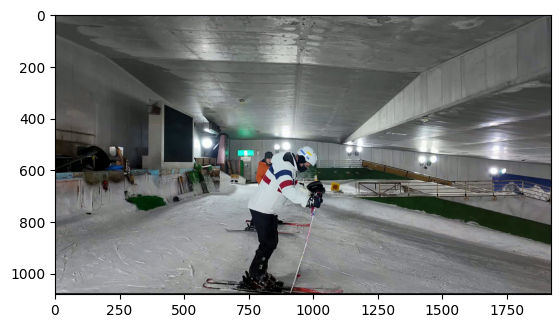

In [11]:
import matplotlib.pyplot as plt

plt.imshow(right_frames[0].numpy())

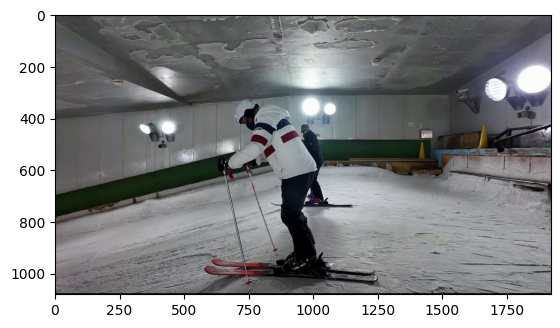

In [55]:
plt.imshow(left_frames[0].numpy())

In [57]:
left_keypoints[0, 0,], right_keypoints[0, 0,]

(tensor([731.8837, 421.3285]), tensor([982.1453, 597.4586]))

In [58]:
left_keypoints[1, 0,], right_keypoints[1, 0,]

(tensor([732.2934, 433.9608]), tensor([983.2352, 600.2333]))

In [59]:
left_keypoints[0, 1,], right_keypoints[0, 1,]

(tensor([726.4521, 406.8996]), tensor([0., 0.]))

In [60]:
for i in range(17):
    print(f"left_kpt: {left_keypoints[0, i,0]}, right_kpt: {right_keypoints[0, i,0]}")

left_kpt: 731.8836669921875, right_kpt: 982.1453247070312
left_kpt: 726.4521484375, right_kpt: 0.0
left_kpt: 0.0, right_kpt: 983.1640625
left_kpt: 747.105712890625, right_kpt: 0.0
left_kpt: 0.0, right_kpt: 960.3533935546875
left_kpt: 809.7138061523438, right_kpt: 909.4791870117188
left_kpt: 851.419921875, right_kpt: 891.8790893554688
left_kpt: 761.599853515625, right_kpt: 935.231201171875
left_kpt: 0.0, right_kpt: 904.9366455078125
left_kpt: 660.009765625, right_kpt: 997.4066162109375
left_kpt: 765.7132568359375, right_kpt: 983.880615234375
left_kpt: 936.6454467773438, right_kpt: 813.57568359375
left_kpt: 958.187255859375, right_kpt: 799.8264770507812
left_kpt: 924.0682983398438, right_kpt: 836.0897827148438
left_kpt: 918.36767578125, right_kpt: 823.9506225585938
left_kpt: 976.9600830078125, right_kpt: 787.0717163085938
left_kpt: 948.891357421875, right_kpt: 772.5811157226562


In [12]:
import torch
import matplotlib.pyplot as plt

def triangulate_from_disparity(pts_l, pts_r, image_size=(1280, 720),
                                focal_length=1000.0, baseline=0.1, cx=None, cy=None):
    """
    使用左右视角的2D点和视差，估算相对3D坐标（以左相机为参考）
    """
    if cx is None: cx = image_size[0] / 2
    if cy is None: cy = image_size[1] / 2

    # 计算视差
    disparity = pts_l[:, 0] - pts_r[:, 0]  # (J, )

    # 深度 = f * B / disparity
    depth = (focal_length * baseline) / (disparity + 1e-6)  # 避免除0

    # 反投影
    x = (pts_l[:, 0] - cx) * depth / focal_length
    y = (pts_l[:, 1] - cy) * depth / focal_length
    z = depth

    points_3d = torch.stack([x, y, z], dim=1)
    return points_3d  # (J, 3)


In [13]:
def plot_3d_pose(pose3d, joint_names=None, title="3D Pose"):

    x, y, z = pose3d[:, 0].cpu().numpy(), pose3d[:, 1].cpu().numpy(), pose3d[:, 2].cpu().numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x, y, z, c='r')
    ax.scatter(x, z, y, c='r')
    for i in range(len(x)):
        ax.text(x[i], y[i], z[i], str(i), fontsize=8)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_zlabel("Y")
    ax.set_title(title)
    # ax.view_init(elev=0, azim=-45)  # elev=仰角, azim=水平角度
    plt.tight_layout()
    plt.show()


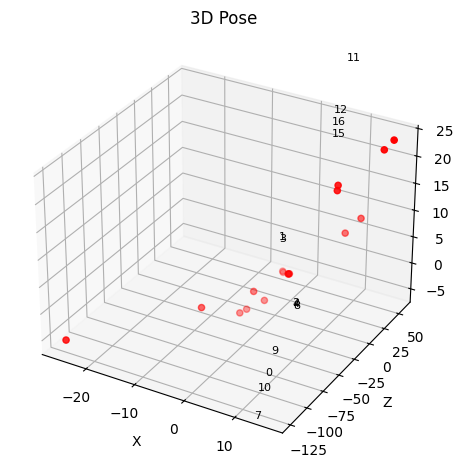

In [14]:
# 假设你已经得到了左右两个 keypoints

pts_l = left_keypoints[0]
pts_r = right_keypoints[0]

pose3d = triangulate_from_disparity(
    pts_l, pts_r,
    image_size=(1280, 720),
    focal_length=1000.0,
    baseline=5
)

plot_3d_pose(pose3d)


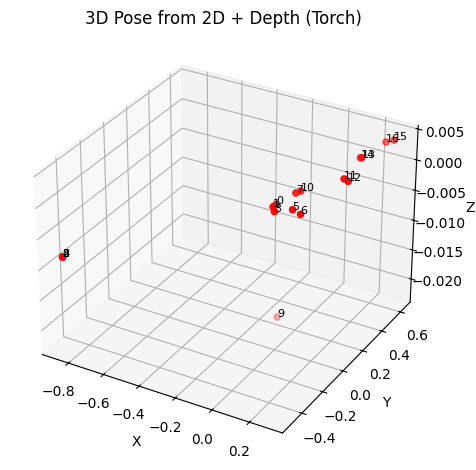

In [15]:
import torch
import matplotlib.pyplot as plt

def build_3d_pose_from_2d_and_depth_torch(keypoints_2d, relative_depth, image_size=(1280, 720), root_index=0):
    cx, cy = image_size[0] / 2, image_size[1] / 2
    x = keypoints_2d[:, 0] - cx
    y = keypoints_2d[:, 1] - cy
    z = relative_depth
    pose3d = torch.stack([x, y, z], dim=1)
    root = pose3d[root_index]
    pose3d_centered = pose3d - root
    scale = torch.norm(pose3d_centered, dim=1).max()
    pose3d_normalized = pose3d_centered / scale
    return pose3d_normalized

# 模拟输入
J = 17

# 构建 3D
pose3d = build_3d_pose_from_2d_and_depth_torch(left_keypoints[0], left_keypoint_depth_values[0], image_size=img_shape)

# 可视化
x, y, z = pose3d[:, 0].numpy(), pose3d[:, 1].numpy(), pose3d[:, 2].numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r')
for i in range(J):
    ax.text(x[i], y[i], z[i], str(i), fontsize=8)
ax.set_title("3D Pose from 2D + Depth (Torch)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


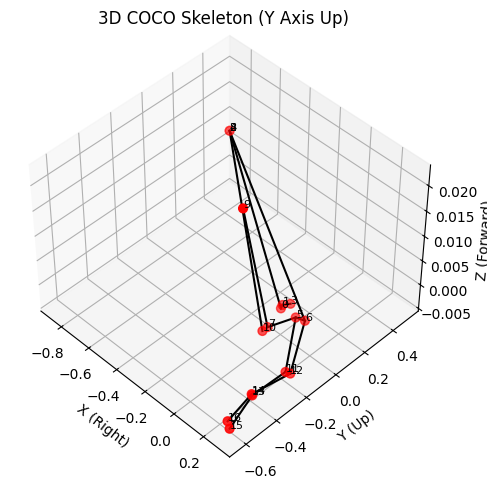

In [16]:
import plotly.graph_objects as go
import torch

def build_3d_pose_from_2d_and_depth_torch(keypoints_2d, relative_depth, image_size=(1280, 720), root_index=0):
    cx, cy = image_size[0] / 2, image_size[1] / 2
    x = keypoints_2d[:, 0] - cx
    y = keypoints_2d[:, 1] - cy
    z = relative_depth
    pose3d = torch.stack([x, y, z], dim=1)
    root = pose3d[root_index]
    pose3d_centered = pose3d - root
    scale = torch.norm(pose3d_centered, dim=1).max()
    pose3d_normalized = pose3d_centered / scale
    return pose3d_normalized


def build_3d_pose_from_2d_and_depth_absolute(keypoints_2d, relative_depth, image_size=(1280, 720)):
    """
    使用图像中心为原点，构建真实尺度的3D姿态（不进行中心化和归一化）
    输入:
        keypoints_2d: (J, 2) 像素坐标 (u, v)
        relative_depth: (J,) 相对或绝对深度值
        image_size: (W, H) 图像大小
    输出:
        pose3d: (J, 3) 真实尺度下的 3D 坐标（单位：像素+深度单位）
    """
    cx, cy = image_size[0] / 2, image_size[1] / 2
    x = keypoints_2d[:, 0]  # X 轴向右
    y = keypoints_2d[:, 1]  # Y 轴向下
    z = relative_depth           # Z 轴向前（或深度方向）

    pose3d = torch.stack([x, y, z], dim=1)
    return pose3d

# 示例数据（你原来的）
J = 17

# 构建 3D
pose3d = build_3d_pose_from_2d_and_depth_torch(left_keypoints[0], left_keypoint_depth_values[0], image_size=img_shape)

# 转换方向（Y 轴向上）
x = pose3d[:, 0].numpy()
y = -pose3d[:, 1].numpy()  # 注意：Y 轴翻转
z = -pose3d[:, 2].numpy()

# COCO skeleton 连接关系（骨架）
coco_skeleton = [
    (0, 1), (0, 2),
    (1, 3), (2, 4),
    (5, 6),
    (5, 7), (7, 9),
    (6, 8), (8,10),
    (5,11), (6,12),
    (11,12),
    (11,13), (13,15),
    (12,14), (14,16)
]

# 可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 画点
ax.scatter(x, y, z, c='r', s=40)
for i in range(J):
    ax.text(x[i], y[i], z[i], str(i), fontsize=8)

# 画连线
for i, j in coco_skeleton:
    ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], c='black')

ax.view_init(elev=45, azim=-45)  # elev=仰角, azim=水平角度

# 坐标轴标签
ax.set_title("3D COCO Skeleton (Y Axis Up)")
ax.set_xlabel("X (Right)")
ax.set_ylabel("Y (Up)")
ax.set_zlabel("Z (Forward)")
plt.tight_layout()
plt.show()

In [17]:
left_keypoint_depth_values[0]

tensor([23.0041, 22.8475, 16.0085, 22.7561, 16.0085, 23.0264, 22.9245, 23.2358,
        16.0085,  4.3288, 23.0523, 25.5081, 25.4364, 25.8000, 25.7542, 26.1205,
        25.8705])

In [18]:

# 提取 x, y, z
# pose3d = build_3d_pose_from_2d_and_depth_torch(keypoints_2d, relative_depth, image_size)
pose3d = build_3d_pose_from_2d_and_depth_absolute(left_keypoints[0], left_keypoint_depth_values[0], image_size=img_shape)

# 👉 方向调整：Y 轴向上，Z 轴向里（符合摄像机观察）
x = pose3d[:, 0].numpy()
y = -pose3d[:, 1].numpy()  # 向上
z = -pose3d[:, 2].numpy()  # 深度往里

# 👉 COCO 关键点连线结构
coco_skeleton = [
    (0, 1), (0, 2),
    (1, 3), (2, 4),
    (5, 6),
    (5, 7), (7, 9),
    (6, 8), (8,10),
    (5,11), (6,12),
    (11,12),
    (11,13), (13,15),
    (12,14), (14,16)
]

# ✅ 绘制关键点（带编号）
scatter = go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers+text',
    text=[str(i) for i in range(J)],
    marker=dict(size=5, color='red'),
    textposition="top center",
    name='keypoints'
)

# ✅ 骨架连线
lines = []
for i, j in coco_skeleton:
    if i < J and j < J:
        lines.append(go.Scatter3d(
            x=[x[i], x[j]],
            y=[y[i], y[j]],
            z=[z[i], z[j]],
            mode='lines',
            line=dict(color='black', width=3),
            showlegend=False
        ))

# ✅ 绘制图形
fig = go.Figure(data=[scatter] + lines)
fig.update_layout(
    title="3D COCO Skeleton (Y Up, Z Inward)",
    scene=dict(
        xaxis_title='X (Right)',
        yaxis_title='Y (Up)',
        zaxis_title='Z (Forward)',
        aspectmode='data'
    )
)
fig.show()